In [9]:
import pandas as pd
import os
import numpy as np
#direc = 'E:/Files/Toronto Courses/Applied Probability for Mathematical Finance/Project 3'
#os.chdir(direc)
da = pd.read_excel('Data for Project 3.xlsx',skiprows = 1)
columns = ['T']
for i in range(1,22):
    columns.append('K'+str(i))

da.columns = columns

In [3]:
##Setup
r=0; S0 = 1
V0 = 0.3**2; kappa = 3;
theta = 0.16; ita = 5; rho =-0.5
nsteps = 1000; nsims = 5000

#### Euler, Milstein and Conditional volatility simulation to estimation option price

In [7]:
#T=1 ; K = 0.9
def EulerDiscretization(S0,K,T,r,V0,kappa,theta,ita,rho,nsteps,nsims,Option,random=1):
    '''Option can be put or call'''
    deltat = T/nsteps
    np.random.seed(random*9)
    Wv = np.random.normal(size = [nsteps,nsims])
    np.random.seed(7*random)
    Wx = rho * Wv + np.sqrt(1-rho*rho) * np.random.normal(size = [nsteps,nsims])
    Vmatrix = np.zeros(shape = [nsteps+1,nsims]); Vmatrix[0,:] = V0
    Xmatrix = np.zeros_like(Vmatrix); Xmatrix[0,:] = np.log(S0)
    for i in np.arange(1,nsteps+1):
        tempV = np.where(Vmatrix[i-1,:]>0,Vmatrix[i-1,:],0)
        Vmatrix[i,:] = Vmatrix[i-1,:] + ( kappa * (theta - tempV) * deltat + 
                       ita * np.sqrt(tempV) * np.sqrt(deltat) * Wv[i-1,:] )

        Xmatrix[i,:] = Xmatrix[i-1,:] + ( (r - 0.5 * tempV) * deltat +
                       np.sqrt(tempV) * np.sqrt(deltat) * Wx[i-1,:] )
    if Option == 'call':
        return(np.exp(-r*T) * np.where(np.exp(Xmatrix[-1,:]) - K>0, np.exp(Xmatrix[-1,:]) - K,0))
    elif Option =='put':
        return(np.exp(-r*T) * np.where( K - np.exp(Xmatrix[-1,:])>0, K - np.exp(Xmatrix[-1,:]),0))
    else:
        Warning('Wrong option type')

def MilsteinDiscretization(S0,K,T,r,V0,kappa,theta,ita,rho,nsteps,nsims,Option,random=1):
    deltat = T/nsteps
    np.random.seed(random*9)
    Wv = np.random.normal(size = [nsteps,nsims])
    np.random.seed(7*random)
    Wx = rho * Wv + np.sqrt(1-rho**2)*np.random.normal(size = [nsteps,nsims])
    Vmatrix = np.zeros(shape = [nsteps+1,nsims]); Vmatrix[0,:] = V0
    Xmatrix = np.zeros_like(Vmatrix); Xmatrix[0,:] = np.log(S0)
    for i in np.arange(1,nsteps+1):
        BoolV = np.where(Vmatrix[i-1,:]>0,True,False)
        tempV = np.where(BoolV,Vmatrix[i-1,:],0)
        Vmatrix[i,:] =Vmatrix[i-1,:] + ( kappa*(theta - tempV) * deltat + 
                       ita * np.sqrt(tempV) * np.sqrt(deltat) * Wv[i-1,:] 
                       + 0.25 * ita**2 * deltat * (Wv[i-1,:]**2 - 1) * BoolV )##if variance is negative, it doesn't ahve this term
        
        Xmatrix[i,:] = Xmatrix[i-1,:] + ( (r - 0.5 * tempV) * deltat +
        np.sqrt(tempV * deltat) * Wx[i-1,:] )
    if Option == 'call':
        return(np.exp(-r*T) * np.where(np.exp(Xmatrix[-1,:]) - K>0, np.exp(Xmatrix[-1,:]) - K,0))
    elif Option =='put':
        return(np.exp(-r*T) * np.where( K - np.exp(Xmatrix[-1,:]) >0, K - np.exp(Xmatrix[-1,:]),0))
    else:
        Warning('Wrong option type')

def MixingConditional(S0,K,T,r,V0,kappa,theta,ita,rho,nsteps,nsims,Option,random=1):
    deltat = T/nsteps
    np.random.seed(random*9)
    Wv = np.random.normal(size = [nsteps,nsims])
    np.random.seed(5*random)
    Vmatrix = np.zeros(shape = [nsteps+1,nsims]); Vmatrix[0,:] = V0
    Z = np.random.normal(size = nsims)
    for i in np.arange(1,nsteps+1):
        BoolV = np.where(Vmatrix[i-1,:]>0,True,False)
        tempV = np.where(BoolV,Vmatrix[i-1,:],0)
        Vmatrix[i,:] = Vmatrix[i-1,:] + ( kappa* (theta - tempV) * deltat + 
                       ita * np.sqrt(tempV * deltat) * Wv[i-1,:] 
                       + 0.25 * ita* ita * deltat * (Wv[i-1,:]**2 - 1) * BoolV  )
    Vmatrix = np.where(Vmatrix>0,Vmatrix,0)
    RootV = np.sqrt(Vmatrix)
    A = np.log(S0) + r*T - 0.5* Vmatrix[:-1,:].sum(axis=0)*deltat + rho *np.sqrt(deltat)* np.sum(RootV[:-1,:]*Wv,axis=0)
    #A +=  ( (r - 0.5 * tempV) * deltat +
    #             rho * np.sqrt(tempV * deltat) * Wv[i-1,:] )
    B = (1- rho**2) * Vmatrix[:-1,:].sum(axis=0) * deltat
    FinalPrice = np.exp(A + np.sqrt(B)*Z)
    if Option == 'call':
        return(  np.exp(-r*T) * np.where(FinalPrice-K>0,FinalPrice-K,0) )
    elif Option =='put':
        return( np.exp(-r*T) * np.where(K - FinalPrice>0,K - FinalPrice,0) )
    else:
        Warning('Wrong option type')

#### Option price and get implied volatility

In [12]:
from scipy.stats import norm
def blsprice(S0,K,T,r,sigma,Option):
    d1 = (np.log(S0/K) + (r+sigma**2*0.5)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if Option == 'call':
        return (S0 * norm.cdf(d1) - K * norm.cdf(d2) * np.exp(-r*T) )
    elif Option =='put':
        return (K * np.exp(-r*T) * norm.cdf(-d2) - norm.cdf(-d1) * S0)

## functions used to find implied volatility
n = norm.pdf
N = norm.cdf
def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    if cp_flag == 'c':
        price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    else:
        price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    return price

def bs_vega(S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    return S * np.sqrt(T)*n(d1)

def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-7

    sigma = 0.5
    for i in np.arange(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)

        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            #print(sigma, price,diff)
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

#### Simulate one scenario of implied volatility using these methods and plot them

We shall see there is a jump at K where we change the option type used to get the implied volatility

if we get the implied volatility multiple times using different simulated path and average them, we shall see that all methods' result is very similar to the real implied volatility given to us.

In [13]:
T = [0.25,1]
K = da.iloc[0,1:].values
EulerImplied = np.zeros([len(T),len(K)])
MilImplied =np.zeros([len(T),len(K)])
MixingImplied = np.zeros([len(T),len(K)])

for i in range(len(T)):
    for j in range(len(K)):
        if S0 <= K[j]:
            MilValue = MilsteinDiscretization(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call').mean()
            MilImplied[i,j] = find_vol(MilValue, 'c',S0,K[j],T[i],r)
            value = MixingConditional(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call').mean()
            MixingImplied[i,j] = find_vol(value, 'c',S0,K[j],T[i],r)
            value = EulerDiscretization(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call').mean()
            EulerImplied[i,j] = find_vol(value, 'c',S0,K[j],T[i],r)
        else:
            MilValue = MilsteinDiscretization(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'put').mean()
            MilImplied[i,j] = find_vol(MilValue, 'p',S0,K[j],T[i],r)
            value = MixingConditional(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'put').mean()
            MixingImplied[i,j] = find_vol(value, 'p',S0,K[j],T[i],r)
            value = EulerDiscretization(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'put').mean()
            EulerImplied[i,j] = find_vol(value, 'p',S0,K[j],T[i],r)

0.2731507082553889 0.016351826410456544 -7.364157207645494e-09
0.2876560477316827 0.018416080069769775 -2.4274043122773925e-09
0.2798047977689286 0.01729133036677491 -4.437327214001918e-09
0.2628309984929682 0.01736095478964414 -3.880870333428099e-09
0.2771911443590762 0.019496650490421458 -1.2744939340003647e-09
0.26952839745892315 0.01835017002907713 -2.3126580858678913e-09
0.2525038027768014 0.018470828312858678 -1.7159679371880898e-09
0.26666426438870783 0.020670005316183626 -5.604624368771294e-10
0.2592306452290553 0.019509412303704066 -1.0092692029339823e-09
0.24201477185306247 0.019672843485475877 -6.11718970616737e-10
0.2561068908502376 0.021955598726598247 -1.9532381961839818e-10
0.24883911691765304 0.02077288271462141 -3.519169712584702e-10
0.23155594936089416 0.021015326339789364 -1.596347047605473e-10
0.2455424488077357 0.023375243457774697 -4.955324345301548e-11
0.23840310877333462 0.022166037978765207 -8.995467912220612e-11
0.2212589224887081 0.02254541761160983 -2.626505

Text(0.5,1,'$T = 1$')

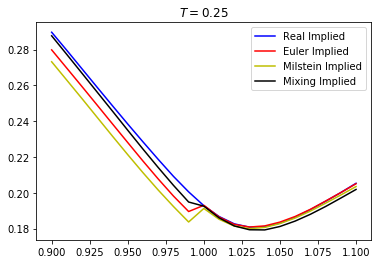

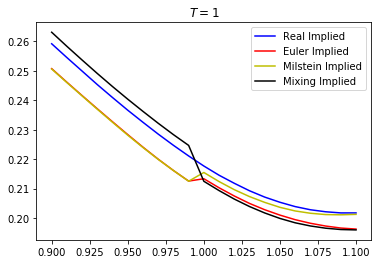

In [14]:
import matplotlib.pyplot as plt
plt.plot(K, da.iloc[1,1:],'b-',label = 'Real Implied')

plt.plot(K,EulerImplied[0,:],'r-',label = 'Euler Implied' )
plt.plot(K,MilImplied[0,:],'y-',label = 'Milstein Implied' )
plt.plot(K,MixingImplied[0,:],'k-',label = 'Mixing Implied')
plt.legend()
plt.title('$T = 0.25$')

plt.figure()
plt.plot(K, da.iloc[2,1:],'b-',label = 'Real Implied')
plt.plot(K,EulerImplied[1,:],'r-',label = 'Euler Implied' )
plt.plot(K,MilImplied[1,:],'y-',label = 'Milstein Implied' )
plt.plot(K,MixingImplied[1,:],'k-',label = 'Mixing Implied')
plt.legend()
plt.title('$T = 1$')

#### Used to compute the value of those contigent claims in (c),(d)

In [5]:
import matplotlib.pyplot as plt
def MilsteinVarianceClaim(S0,T,V0,kappa,theta,ita,nsteps,nsims,Type,random=1):
    deltat = T/nsteps
    np.random.seed(9*random)
    Wv = np.random.normal(size = [nsteps,nsims])
    Vmatrix = np.zeros(shape = [nsteps+1,nsims]); Vmatrix[0,:] = V0
    value = np.zeros(nsims)
    for i in np.arange(1,nsteps+1):
        BoolV = np.where(Vmatrix[i-1,:]>0,True,False)
        tempV = np.where(BoolV,Vmatrix[i-1,:],0)
        Vmatrix[i,:] =Vmatrix[i-1,:] + ( kappa*(theta - tempV) * deltat + 
                       ita * np.sqrt(tempV * deltat) * Wv[i-1,:] 
                       + 0.25 * ita**2 * deltat * (Wv[i-1,:]**2 - 1) * BoolV ) 
        if Type == '1':
            value = value + tempV * deltat
        elif Type == '2':
            value = value + tempV * tempV * deltat
        else:
            Warning('no type')
    return value

def ThereticalVarianceClaim(S0,T,V0,kappa,theta,ita,Type):
    if Type == '1':
        return (V0-theta)*(1-np.exp(-kappa*T))/kappa + theta * T
    elif Type == '2':
        a = (V0 - theta)**2 - ita**2/kappa * (V0 - theta/2)
        b = 2*theta * (V0 - theta) + (V0 - theta) * ita**2 /kappa
        c = theta**2 + ita**2 * theta /(2*kappa)
        a1 = (1 - np.exp(-2*kappa*T))/(2*kappa)
        b1 = (1 - np.exp(-kappa*T))/kappa
        return a*a1 + b*b1 + c * T
    else:
        return

maturities = np.arange(0.1,1.1,0.1)
theoretical = np.zeros([2,len(maturities)])
MilDis = np.zeros([2,len(maturities)])
for i,maturity in enumerate(maturities):
    theoretical[0,i] = ThereticalVarianceClaim(S0,maturity,V0,kappa,theta,ita,'1')
    theoretical[1,i] = ThereticalVarianceClaim(S0,maturity,V0,kappa,theta,ita,'2')
    MilDis[0,i] = MilsteinVarianceClaim(S0,maturity,V0,kappa,theta,ita,nsteps,nsims,'1',3).mean()
    MilDis[1,i] = MilsteinVarianceClaim(S0,maturity,V0,kappa,theta,ita,nsteps,nsims,'2',3).mean()
    #print('Theoretical value(1) = ',theoretical[0,i])
    #print('Theoretical value(2) = ',theoretical[1,i])
    #print('Discretization Value(1) = ',MilDis[0,i])
    #print('Discretization Value(2) = ', MilDis[1,i])


Theoretical value(1) =  0.009952425149240083
Theoretical value(2) =  0.010996951067697755
Discretization Value(1) =  0.009961290461148093
Discretization Value(2) =  0.010678393661029103
Theoretical value(1) =  0.021472271508860614
Theoretical value(2) =  0.038218444904615026
Discretization Value(1) =  0.02183455069288124
Discretization Value(2) =  0.03782659414520383
Theoretical value(1) =  0.03415329206061398
Theoretical value(2) =  0.07694842220887624
Discretization Value(1) =  0.034330482723730966
Discretization Value(2) =  0.07310281040981906
Theoretical value(1) =  0.047694531611284716
Theoretical value(2) =  0.12392367656570583
Discretization Value(1) =  0.0500991223754224
Discretization Value(2) =  0.13015667791482446
Theoretical value(1) =  0.06187303707013003
Theoretical value(2) =  0.17685328617946727
Discretization Value(1) =  0.06552908360179181
Discretization Value(2) =  0.19684921160163982
Theoretical value(1) =  0.07652364072517036
Theoretical value(2) =  0.2341095306246

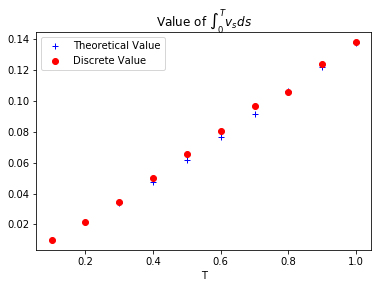

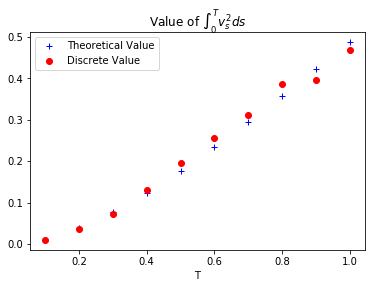

In [6]:
plt.plot(maturities,theoretical[0,:],'b+',label = 'Theoretical Value')
plt.plot(maturities,MilDis[0,:],'ro',label = 'Discrete Value')
plt.title('Value of $\int_0^T v_s ds$')
plt.xlabel('T')
plt.legend()

plt.figure()
plt.plot(maturities,theoretical[1,:],'b+',label = 'Theoretical Value')
plt.plot(maturities,MilDis[1,:],'ro',label = 'Discrete Value')
plt.title('Value of $\int_0^T v_s^2 ds$')
plt.xlabel('T')
plt.legend()

In [15]:
#%% (e) 
def MilsteinBar(S0,K,T,r,V0,kappa,theta,ita,rho,nsteps,nsims,Option,random=1):
    deltat = T/nsteps
    np.random.seed(9*random)
    Wv = np.random.normal(size = [nsteps,nsims])
    np.random.seed(7*random)
    Wx = rho * Wv + np.sqrt(1-rho**2)*np.random.normal(size = [nsteps,nsims])
    Vmatrix = np.zeros(shape = [nsteps+1,nsims]); Vmatrix[0,:] = V0
    Xmatrix = np.zeros_like(Vmatrix); Xmatrix[0,:] = np.log(S0)
    ##
    XbarMatrix = np.zeros_like(Vmatrix); XbarMatrix[0,:] = np.log(S0)
    for i in np.arange(1,nsteps+1):
        BoolV = np.where(Vmatrix[i-1,:]>0,True,False)
        tempV = np.where(BoolV,Vmatrix[i-1,:],0)
        Vmatrix[i,:] =Vmatrix[i-1,:] + ( kappa*(theta - tempV) * deltat + 
                       ita * np.sqrt(tempV) * np.sqrt(deltat) * Wv[i-1,:] 
                       + 0.25 * ita**2 * deltat * (Wv[i-1,:]**2 - 1) * BoolV )
        Xmatrix[i,:] = Xmatrix[i-1,:] + ( (r - 0.5 * tempV) * deltat +
                       np.sqrt(tempV * deltat) * Wx[i-1,:] )
        ## expectation of v
        Vbar = (V0 - theta) * np.exp(-kappa * (i-1) * deltat) + theta
        #integral_Vbar = (V0 - theta)*(1 - np.exp(-kappa * i *deltat))/kappa + theta * i * deltat
        XbarMatrix[i,:] = (XbarMatrix[i-1,:] + r * deltat - 0.5 * Vbar * deltat 
                          + np.sqrt(Vbar * deltat) * Wx[i-1,:] )

    if Option == 'call':
        return[np.exp(-r*T) * np.where(np.exp(Xmatrix[-1,:]) - K>0, np.exp(Xmatrix[-1,:]) - K,0)
            ,np.exp(-r*T) * np.where(np.exp(XbarMatrix[-1,:]) - K>0, np.exp(XbarMatrix[-1,:]) - K,0)]
    elif Option =='put':
        return[np.exp(-r*T) * np.where( K - np.exp(Xmatrix[-1,:]) >0, K - np.exp(Xmatrix[-1,:]),0)
              ,np.exp(-r*T) * np.where( K - np.exp(XbarMatrix[-1,:]) >0, K - np.exp(XbarMatrix[-1,:]),0)]
    else:
        Warning('Wrong option type')

In [21]:
MilImplied = np.zeros([len(T),len(K)])
VbarImplied = np.zeros([len(T),len(K)])
##
for i in range(len(T)):
    for j in range(len(K)):
        if S0 <= K[j]:
            MilValue = MilsteinBar(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call')[0].mean()
            MilImplied[i,j] = find_vol(MilValue, 'c',S0,K[j],T[i],r)
            value = MilsteinBar(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call')[1].mean()
            VbarImplied[i,j] = find_vol(value, 'c',S0,K[j],T[i],r)
        else:
            MilValue = MilsteinBar(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'put')[0].mean()
            MilImplied[i,j] = find_vol(MilValue, 'p',S0,K[j],T[i],r)
            value = MilsteinBar(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'put')[1].mean()
            VbarImplied[i,j] = find_vol(value, 'p',S0,K[j],T[i],r)

0.2731507082553889 0.016351826410456544 -7.364157207645494e-09
0.3277363525622705 0.024392438843993003 -9.860012112339334e-11
0.2628309984929682 0.01736095478964414 -3.880870333428099e-09
0.3281794831481619 0.027454122205355647 -2.0714208126548783e-11
0.2525038027768014 0.018470828312858678 -1.7159679371880898e-09
0.32859033827009765 0.030753231542751835 -3.5257283204082057e-12
0.24201477185306247 0.019672843485475877 -6.11718970616737e-10
0.32883216241679425 0.03426934953174915 -4.611033777024431e-13
0.23155594936089416 0.021015326339789364 -1.596347047605473e-10
0.32910576679572834 0.03803857744024797 -4.0994985184283905e-14
0.2212589224887081 0.02254541761160983 -2.6265052632812314e-11
0.32943304069895607 0.042067563700490584 -5.23300908508717e-08
0.21119343209732988 0.024307579239042865 -2.0769393149766557e-12
0.32964757780209375 0.04632655780259837 -9.186877023004136e-09
0.2015148612784179 0.02636976601492058 -4.093253513914874e-14
0.32981374075241693 0.05082655608583042 -4.980157

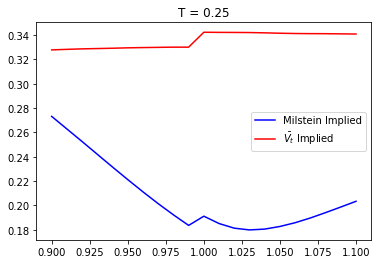

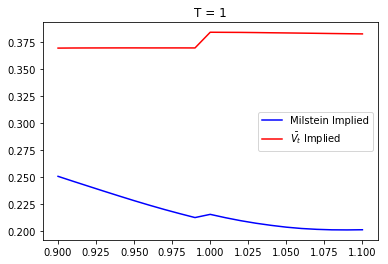

In [20]:
plt.plot(K,MilImplied[0,:],'b-',label = 'Milstein Implied')
plt.plot(K,VbarImplied[0,:],'r-',label = r'$\bar{V_t}$ Implied')
plt.title('T = 0.25')
plt.legend()

plt.figure()
plt.plot(K,MilImplied[1,:],'b-',label = 'Milstein Implied')
plt.plot(K,VbarImplied[1,:],'r-',label = r'$\bar{V_t}$ Implied')
plt.title('T = 1')
plt.legend()

In [22]:
#%% (f) control variate
T = [0.25,1]
K = da.iloc[0,1:].values
MilImplied_Con = np.zeros_like(EulerImplied)
MilstdComparison = np.zeros([2*len(T),len(K)])

for i in range(len(T)):
    Y2 = MilsteinVarianceClaim(S0,T[i],V0,kappa,theta,ita,nsteps,nsims,'1',3)
    EY2 = ThereticalVarianceClaim(S0,T[i],V0,kappa,theta,ita,'1')
    Y3 = MilsteinVarianceClaim(S0,T[i],V0,kappa,theta,ita,nsteps,nsims,'2',3)
    EY3 = ThereticalVarianceClaim(S0,T[i],V0,kappa,theta,ita,'2')
    for j in range(len(K)):
        if(S0>K[j]):
            Y1 = MilsteinBar(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call',3)[1]
            variance = (V0 - theta)*(1 - np.exp(-kappa * T[i]))/kappa + theta * T[i]
            EY1 = blsprice(S0,K[j],T[i],r,np.sqrt(variance),'call')
            C = np.vstack((Y1 - EY1,Y2 - EY2,Y3 - EY3))
            CC = np.dot(C , np.transpose(C))
            X = MilsteinDiscretization(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call',3)
            print('T = ',str(T[i]),' K = ',str(K[j]))
            print('Original std = ', str(X.std(ddof=1)))
            CX = np.dot(C,X)
            Lambda = np.linalg.solve(CC,CX)
            MilValue = X - np.dot(Lambda,C)
            print('Controled std = ', str(MilValue.std(ddof=1)))
            MilstdComparison[2*i,j] = X.std(ddof=1) ; MilstdComparison[2*i+1,j] = MilValue.std(ddof=1) 
            MilImplied_Con[i,j] = find_vol(MilValue.mean(), 'c',S0,K[j],T[i],r)
        else:
            Y1 = MilsteinBar(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call',3)[1]
            variance = (V0 - theta)*(1 - np.exp(-kappa * T[i]))/kappa + theta * T[i]
            EY1 = blsprice(S0,K[j],T[i],r,np.sqrt(variance),'call')
            C = np.vstack((Y1 - EY1,Y2 - EY2,Y3 - EY3))
            CC = np.dot(C , np.transpose(C))
            X = MilsteinDiscretization(S0,K[j],T[i],r,V0,kappa,theta,ita,rho,nsteps,nsims,'call',3)
            print('T = ',str(T[i]),' K = ',str(K[j]))
            print('Original std = ', str(X.std(ddof=1)))
            CX = np.dot(C,X)
            Lambda = np.linalg.solve(CC,CX)
            MilValue = X - np.dot(Lambda,C)
            print('Controled std = ', str(MilValue.std(ddof=1)))
            MilstdComparison[2*i,j] = X.std(ddof=1) ; MilstdComparison[2*i+1,j] = MilValue.std(ddof=1) 
            MilImplied_Con[i,j] = find_vol(MilValue.mean(), 'c',S0,K[j],T[i],r)


T =  0.25  K =  0.9
Original std =  0.09914333290435139
Controled std =  0.09502261390922138
0.24028540555723021 0.11192521375103626 -8.532336888411596e-08
T =  0.25  K =  0.91
Original std =  0.0978515019012169
Controled std =  0.09401176212432369
0.2268687688320258 0.10229097828409373 -6.030547634872097e-08
T =  0.25  K =  0.92
Original std =  0.09652512210852374
Controled std =  0.09291703664244681
0.21419135579212265 0.09281046337291554 -3.489249190968824e-08
T =  0.25  K =  0.93
Original std =  0.09514891772565687
Controled std =  0.09171982912441515
0.20237988002973525 0.08353187007699792 -1.5533917555043963e-08
T =  0.25  K =  0.94
Original std =  0.09373360648792457
Controled std =  0.09041996537018912
0.19154207624717667 0.07451186506974061 -4.850735965677977e-09
T =  0.25  K =  0.95
Original std =  0.09229550325773758
Controled std =  0.08903871656199498
0.18158128752991115 0.06578610685929154 -9.324049449199734e-10
T =  0.25  K =  0.96
Original std =  0.09081705454205036
Con

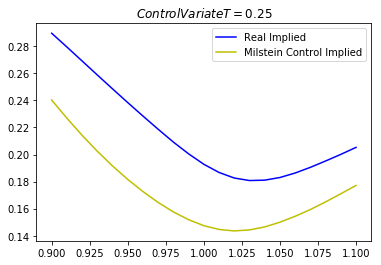

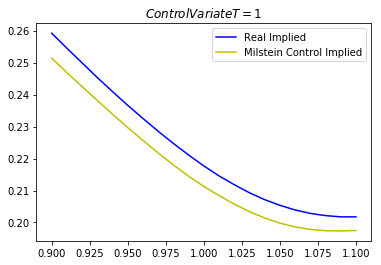

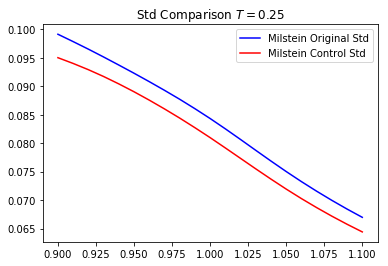

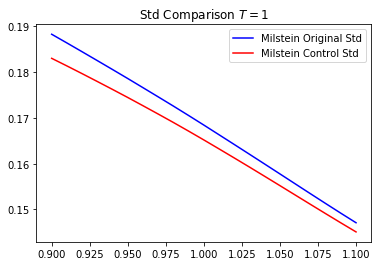

In [23]:
plt.plot(K, da.iloc[1,1:],'b-',label = 'Real Implied')
plt.plot(K,MilImplied_Con[0,:],'y-',label = 'Milstein Control Implied' )
plt.title('$Control Variate T = 0.25 $')
plt.legend()

plt.figure()
plt.plot(K, da.iloc[2,1:],'b-',label = 'Real Implied')
plt.plot(K,MilImplied_Con[1,:],'y-',label = 'Milstein Control Implied' )
plt.title('$Control Variate T = 1 $')
plt.legend()

plt.figure()
plt.plot(K, MilstdComparison[0,:],'b-',label = 'Milstein Original Std')
plt.plot(K, MilstdComparison[1,:],'r-',label = 'Milstein Control Std')
plt.title('Std Comparison $T = 0.25$')
plt.legend()

plt.figure()
plt.plot(K, MilstdComparison[2,:],'b-',label = 'Milstein Original Std')
plt.plot(K, MilstdComparison[3,:],'r-',label = 'Milstein Control Std')
plt.title('Std Comparison $T = 1$')
plt.legend()